In [1]:
#debo instalar el unicode

import subprocess

def install_package(package):
    subprocess.check_call(["pip", "install", package])

# Instalar unidecode
install_package("unidecode")

In [2]:
#se debe instalar
import subprocess

def install_package(package):
    subprocess.check_call(["pip", "install", package])

# Instalar openpyxl
install_package("openpyxl")

In [3]:
import openpyxl

In [33]:
#mapa de provincias
import os
import geopandas as gpd

os.environ['USE_PYGEOS'] = '0'

dataprovmap=gpd.read_file(os.path.join('maps','DistritosMap.zip'))

dataprovmap.head()

DEPARTAMEN PROVINCIA                              DISTRITO INSTITUCIO  \
0      TACNA     TACNA  CORONEL GREGORIO ALBARRACIN LANCHIPA        IGN   
1      TACNA     TACNA                              POCOLLAY        IGN   
2      TACNA     TACNA                                CALANA        IGN   
3      TACNA     TACNA                                 TACNA        IGN   
4      TACNA     TACNA                                  SAMA        IGN   

                                            geometry  
0  POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...  
1  POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...  
2  POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...  
3  POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...  
4  POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...

In [34]:
#la data de las tablas (en este caso provincias)
import pandas as pd
import os

dataprov=pd.read_excel(os.path.join('data','dataPeru_indicadores.xlsx')
                        )
dataprov.head()


Departamento     Provincia  Hog_sin_agua_pct  Hog_sin_desague_pct  \
0     Amazonas   CHACHAPOYAS         33.922889            36.076371   
1     Amazonas         BAGUA         46.670184            63.266503   
2     Amazonas       BONGARA         51.710048            54.721550   
3     Amazonas  CONDORCANQUI         92.064220            97.167431   
4     Amazonas          LUYA         72.366309            65.633184   

   Hog_sin_alumbrado_pct  
0              27.669651  
1              48.704420  
2              44.794189  
3              90.000000  
4              48.948213

In [35]:
#se debe quitar los espacios en blanco y que las letras esten uniformes
capitalizeColumns=lambda x: x.str.upper().str.strip()
dataprov[['Departamento','Provincia']]=dataprov[['Departamento','Provincia']].apply(capitalizeColumns)
dataprovmap[['DEPARTAMEN','PROVINCIA']]=dataprovmap[['DEPARTAMEN','PROVINCIA']].apply(capitalizeColumns)

In [36]:
#se quita los acentos
import unidecode


byePunctuation=lambda x: unidecode.unidecode(x)
dataprov[['Departamento','Provincia']]=dataprov[['Departamento','Provincia']].applymap(byePunctuation)
dataprovmap[['DEPARTAMEN','PROVINCIA']]=dataprovmap[['DEPARTAMEN','PROVINCIA']].applymap(byePunctuation)

In [37]:
#para ver la cantidad de datos tanto del GDF y del DF
len(dataprov.Provincia),len(dataprovmap.PROVINCIA)

(195, 1874)

In [38]:
#para ver si hay duplicados
dataprov.Provincia.duplicated().sum(),dataprovmap.PROVINCIA.duplicated().sum()

(0, 1678)

In [39]:
#se debe concatenar
dataprov['provDep']=["+".join(pd) for pd in zip (dataprov.Departamento,dataprov.Provincia)]
dataprovmap['provDep']=["+".join(pd) for pd in zip (dataprovmap.DEPARTAMEN,dataprovmap.PROVINCIA)]

In [40]:
#la nueva columna uniendo departamento y provincia
dataprov['provDep'].head()

0     AMAZONAS+CHACHAPOYAS
1           AMAZONAS+BAGUA
2         AMAZONAS+BONGARA
3    AMAZONAS+CONDORCANQUI
4            AMAZONAS+LUYA
Name: provDep, dtype: object

In [41]:
#se debe sacar los guiones
dataprov.provDep=dataprov.provDep.str.replace("\-|\_|\s+"," ",regex=True)
dataprovmap.provDep=dataprovmap.provDep.str.replace("\-|\_|\s+"," ",regex=True)

In [42]:
#se debe ver que no coincide
nomatch_df=set(dataprov.provDep)- set(dataprovmap.provDep)
nomatch_gdf=set(dataprovmap.provDep)-set(dataprov.provDep) 

In [43]:
len(nomatch_df), len(nomatch_gdf)

(5, 6)

In [44]:
pip install thefuzz

Note: you may need to restart the kernel to use updated packages.


In [45]:
import thefuzz

In [46]:
pip install python-Levenshtein

Note: you may need to restart the kernel to use updated packages.


In [47]:
#ya que el valor no es 0, se debe hacer un fuzzy merging

from thefuzz import process
[(dis,process.extractOne(dis,nomatch_gdf)) for dis in sorted(nomatch_df)]

[('ANCASH+CARLOS F. FITZCARRALD', ('ANCASH+CARLOS FERMIN FITZCARRALD', 91)),
 ('UCAYALLI+ATALAYA', ('UCAYALI+ATALAYA', 97)),
 ('UCAYALLI+CORONEL PORTILLO', ('UCAYALI+CORONEL PORTILLO', 98)),
 ('UCAYALLI+PADRE ABAD', ('UCAYALI+PADRE ABAD', 97)),
 ('UCAYALLI+PURUS', ('UCAYALI+PURUS', 96))]

In [48]:
#es un diccionario
{dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

{'ANCASH+CARLOS F. FITZCARRALD': 'ANCASH+CARLOS FERMIN FITZCARRALD',
 'UCAYALLI+ATALAYA': 'UCAYALI+ATALAYA',
 'UCAYALLI+CORONEL PORTILLO': 'UCAYALI+CORONEL PORTILLO',
 'UCAYALLI+PADRE ABAD': 'UCAYALI+PADRE ABAD',
 'UCAYALLI+PURUS': 'UCAYALI+PURUS'}

In [49]:
#se hace cambio
changesprov_df={dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

In [50]:
dataprov.provDep.replace(changesprov_df,inplace=True)

In [51]:
dataprovmap=dataprovmap.merge(dataprov, on='provDep')

In [52]:
#nos fijamos que aparezca el que creamos
dataprovmap.info()
#sí sale

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   DEPARTAMEN             1870 non-null   object  
 1   PROVINCIA              1870 non-null   object  
 2   DISTRITO               1870 non-null   object  
 3   INSTITUCIO             1870 non-null   object  
 4   geometry               1870 non-null   geometry
 5   provDep                1870 non-null   object  
 6   Departamento           1870 non-null   object  
 7   Provincia              1870 non-null   object  
 8   Hog_sin_agua_pct       1870 non-null   float64 
 9   Hog_sin_desague_pct    1870 non-null   float64 
 10  Hog_sin_alumbrado_pct  1870 non-null   float64 
dtypes: float64(3), geometry(1), object(7)
memory usage: 160.8+ KB


In [53]:
bye=['Departamento','Provincia','DISTRITO','INSTITUCIO']
dataprovmap.drop(columns=bye,inplace=True)

# keeping
dataprovmap.head()

DEPARTAMEN PROVINCIA                                           geometry  \
0      TACNA     TACNA  POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...   
1      TACNA     TACNA  POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...   
2      TACNA     TACNA  POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...   
3      TACNA     TACNA  POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...   
4      TACNA     TACNA  POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...   

       provDep  Hog_sin_agua_pct  Hog_sin_desague_pct  Hog_sin_alumbrado_pct  
0  TACNA+TACNA          9.775825            20.815686              16.753091  
1  TACNA+TACNA          9.775825            20.815686              16.753091  
2  TACNA+TACNA          9.775825            20.815686              16.753091  
3  TACNA+TACNA          9.775825            20.815686              16.753091  
4  TACNA+TACNA          9.775825            20.815686              16.753091

In [54]:
dataprovmap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='provinciaPeru', driver="GPKG")

In [55]:
#queremos la estadistica de hogares son agua
dataprovmap.Hog_sin_agua_pct.describe()

count    1870.000000
mean       47.644073
std        22.109732
min         2.832589
25%        29.432882
50%        47.201632
75%        67.491015
max        99.472296
Name: Hog_sin_agua_pct, dtype: float64

In [57]:
pip install seaborn

     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     -------- ------------------------------ 61.4/293.3 kB 1.6 MB/s eta 0:00:01
     -------------------------------------  286.7/293.3 kB 3.5 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


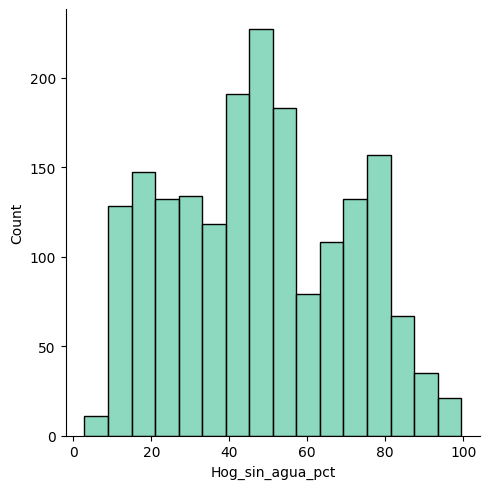

In [58]:
import seaborn as sea
#hacemos un histograma de los hogares sin agua 
sea.displot(dataprovmap.Hog_sin_agua_pct, color='mediumaquamarine')

<Axes: >

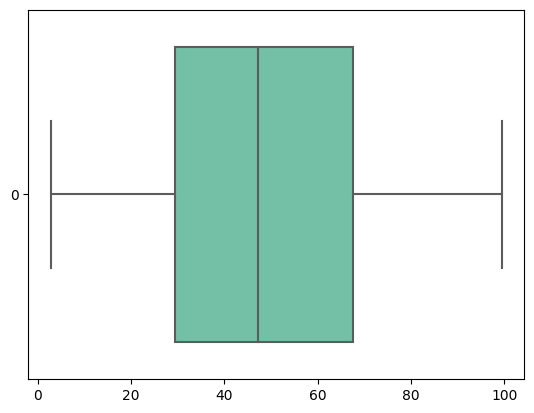

In [59]:
#se hace un boxplot
sea.boxplot(dataprovmap.Hog_sin_agua_pct, color='mediumaquamarine',orient='h')

In [62]:
pip install numba

Note: you may need to restart the kernel to use updated packages.


In [63]:
import mapclassify 
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(dataprovmap['Hog_sin_agua_pct'], k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(dataprovmap['Hog_sin_agua_pct'])
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts                                
q5=mapclassify.Quantiles(dataprovmap['Hog_sin_agua_pct'],k=K)

# based on similarity, good for multimodal data 
mb5 = mapclassify.MaximumBreaks(dataprovmap['Hog_sin_agua_pct'], k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(dataprovmap['Hog_sin_agua_pct']) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(dataprovmap['Hog_sin_agua_pct'], k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(dataprovmap['Hog_sin_agua_pct'], k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(dataprovmap['Hog_sin_agua_pct'], k=K) 

In [64]:
#es una tabla de frecuencias ya dada
ht

HeadTailBreaks

   Interval      Count
----------------------
[ 2.83, 47.64] |   985
(47.64, 66.97] |   412
(66.97, 77.43] |   302
(77.43, 85.61] |    94
(85.61, 91.13] |    40
(91.13, 95.07] |    16
(95.07, 96.91] |    11
(96.91, 97.76] |     4
(97.76, 98.16] |     5
(98.16, 99.47] |     1

In [65]:
# group label
ht.yb

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
# labels and counts
np.unique(ht.yb,return_counts=True)
          

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([985, 412, 302,  94,  40,  16,  11,   4,   5,   1], dtype=int64))

In [67]:
# ht.yb into a pandas Series

pd.Series(ht.yb).value_counts()

0    985
1    412
2    302
3     94
4     40
5     16
6     11
8      5
7      4
9      1
Name: count, dtype: int64

In [68]:
#son los cortes pero no acepta los minimos
ht.bins

array([47.64407327, 66.96547178, 77.43142043, 85.61494249, 91.12645117,
       95.07085079, 96.91024177, 97.76438779, 98.16230303, 99.47229551])

In [69]:
# se debe completar el minimo
HT_bins=list(ht.bins)
HT_bins.insert(0,dataprovmap.Hog_sin_agua_pct.min())

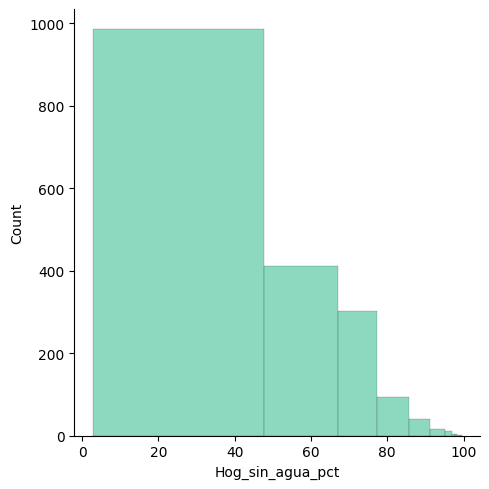

In [70]:
sea.displot(dataprovmap.Hog_sin_agua_pct, bins=HT_bins,color='mediumaquamarine')

In [71]:
class5 = q5, ei5,msd, ht, mb5, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
ax = sea.barplot(
    y='Classifier', x='ADCM', data=adcms, palette='Pastel1'
)
#se debe escoger los que tienen menores valores 
#fisherjenks, jenkscaspall, equalinterval

In [73]:
dataprovmap['EQ'] = ei5.yb 
dataprovmap['FJ'] = fj5.yb
dataprovmap['JC'] = jc5.yb

In [74]:
# haow many cases per scheme:

class5new = q5,fj5, jc5
pd.DataFrame(
    {c.name: c.counts for c in class5new},
    index=['Class-{}'.format(i) for i in range(5)]
)

Quantiles  FisherJenks  JenksCaspall
Class-0        383          390           418
Class-1        370          373           314
Class-2        378          587           435
Class-3        368          391           230
Class-4        371          129           473

In [75]:
#SE GRAFICO EL DE EQUALINTERVAL
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(9, 9))
dataprovmap.plot(column='EQ', 
        cmap='viridis', 
        categorical=True,
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

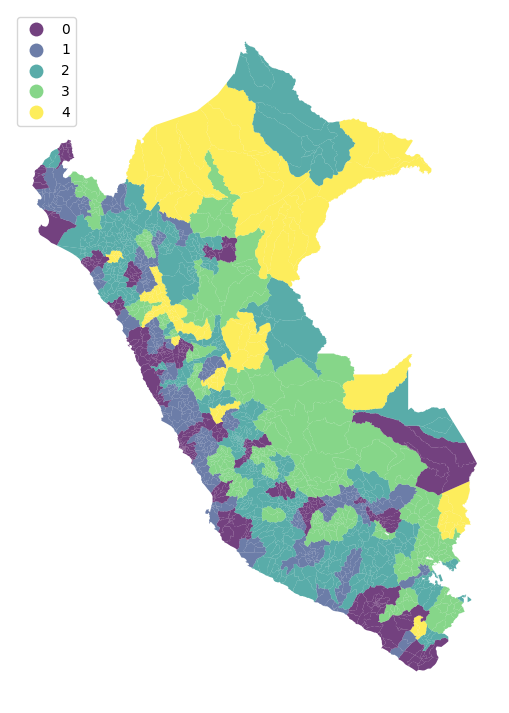

In [76]:
#SE GRAFICO EL DE fisherjenks
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(9, 9))
dataprovmap.plot(column='FJ', 
        cmap='viridis', 
        categorical=True,
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

In [77]:
#SE GRAFICO EL DE jenkscaspall
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(9, 9))
dataprovmap.plot(column='JC', 
        cmap='viridis', 
        categorical=True,
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

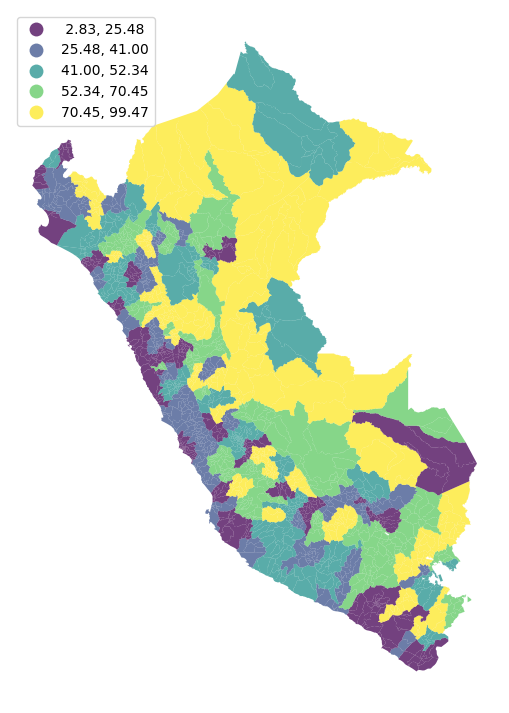

In [79]:
#aqui no se analiza por grupos solo se escoge uno sin importar cual 
f, ax = plt.subplots(1, figsize=(9, 9))
dataprovmap.plot(column='Hog_sin_agua_pct', 
        cmap='viridis',       
        scheme='Quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

In [80]:
#actualizamos nuestro gpkg
dataprovmap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='provinciaPeru', driver="GPKG")

In [81]:
#ahora vamos a escoger las 3 variables para compararlas (me sale sus estadisticas)
selected_variables = ['Hog_sin_agua_pct',
                     'Hog_sin_desague_pct', 
                     'Hog_sin_alumbrado_pct']
dataprovmap[selected_variables].describe()

Hog_sin_agua_pct  Hog_sin_desague_pct  Hog_sin_alumbrado_pct
count       1870.000000          1870.000000            1870.000000
mean          47.644073            62.918902              40.119409
std           22.109732            21.379157              19.532337
min            2.832589            10.158830               4.942090
25%           29.432882            49.742033              25.576088
50%           47.201632            66.837448              39.357005
75%           67.491015            80.001137              55.512789
max           99.472296            97.167431              90.000000

In [83]:
#se hace un boxplot
sea.boxplot(dataprovmap[selected_variables])

<Axes: >

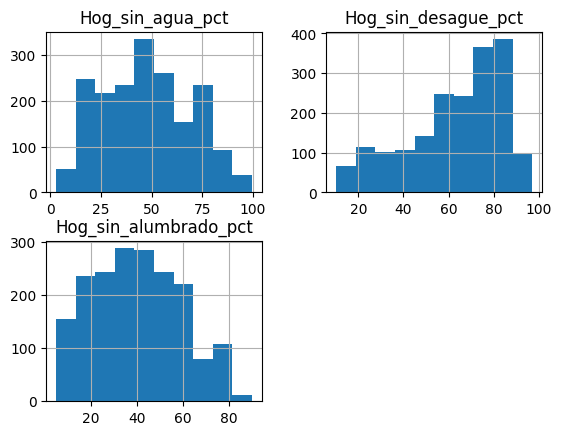

In [85]:
#se hacen los histogramas
dataprovmap[selected_variables].hist();

In [86]:
#las correlaciones deben tener el mismo sentido para poder continuar, como sí las tienen no se modifica
sea.pairplot(
    dataprovmap[selected_variables], kind="reg", diag_kind="kde"
)

In [88]:
columnsToScale=selected_variables


from sklearn.preprocessing import robust_scale as rs
from sklearn.preprocessing import power_transform as pt
from sklearn.preprocessing import quantile_transform as qt

rs_result=rs(dataprovmap[columnsToScale])
pt_result=pt(dataprovmap[columnsToScale])
qt_result=qt(dataprovmap[columnsToScale])

In [89]:
pd.DataFrame(rs_result).boxplot(vert=False)

<Axes: >

<Axes: >

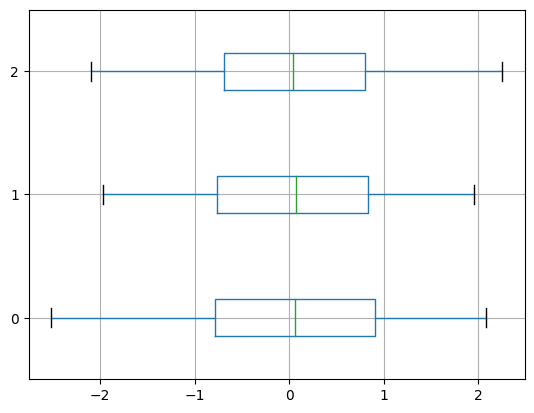

In [90]:
pd.DataFrame(pt_result).boxplot(vert=False)

<Axes: >

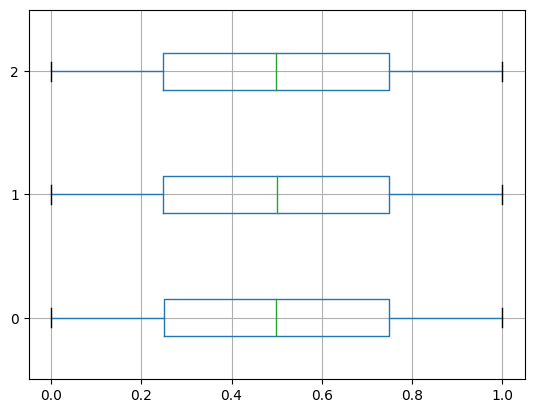

In [91]:
#escojo el de aquí
pd.DataFrame(qt_result).boxplot(vert=False)

In [93]:
#se le cambia de nombre
selected_variables_new_t=[s+'_t' for s in selected_variables]

#y se agrega la columna de qt_result
dataprovmap[selected_variables_new_t]=qt_result

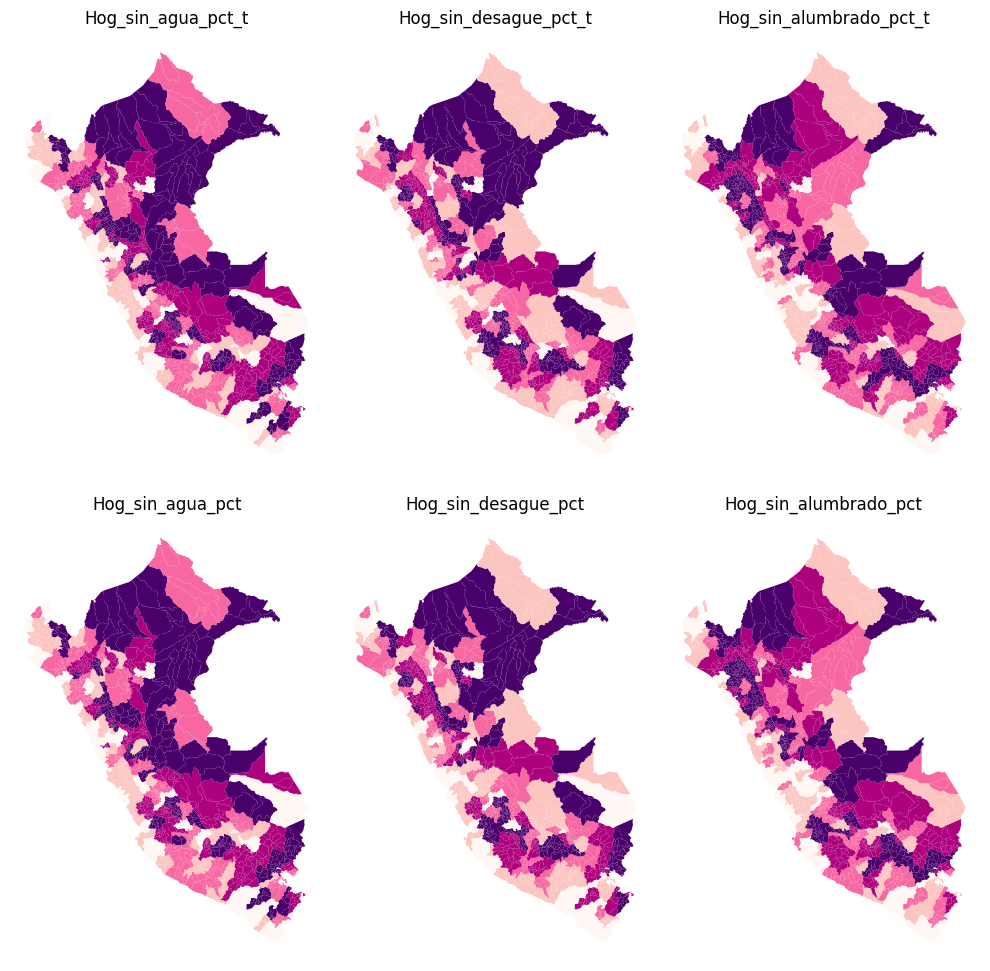

In [95]:
import math

# Calcular el número de filas y columnas necesarias en función del número de variables
num_variables = len(selected_variables_new_t) + len(selected_variables)
num_rows = math.ceil(num_variables / 3)
num_cols = min(num_variables, 3)

# Crear la figura y los ejes con el tamaño adecuado
fig, axs = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(10, 10))
axs = axs.flatten()

# Iterar sobre todas las variables de interés
for i, col in enumerate(selected_variables_new_t + selected_variables):
    if i < num_variables:
        # Seleccionar el eje donde se ubicará el mapa
        ax = axs[i]
        # Graficar el mapa
        dataprovmap.plot(
            column=col,
            ax=ax,
            scheme="Quantiles",
            linewidth=0,
            cmap="RdPu",
        )
        # Quitar los ejes y las etiquetas
        ax.set_axis_off()
        # Establecer el título del eje como el nombre de la variable
        ax.set_title(col)

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [96]:
dataprovmap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='provinciaPeru', driver="GPKG")

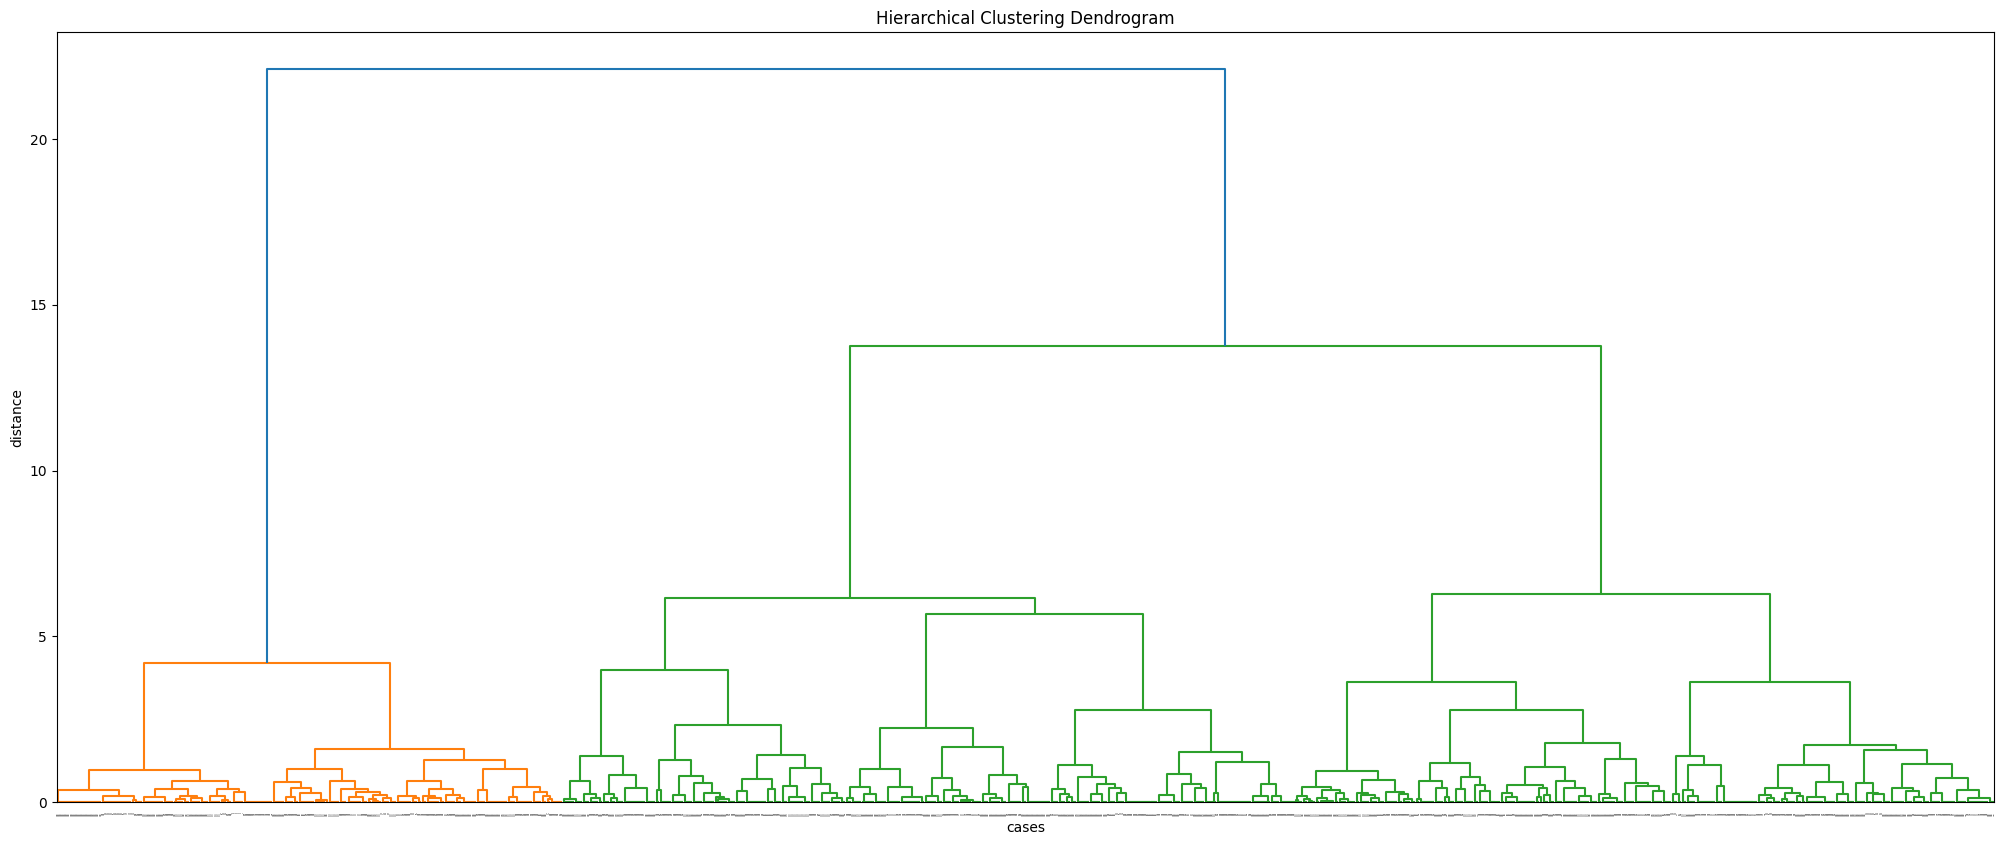

In [97]:
#ahora podemos organizar la data
from scipy.cluster import hierarchy as hc


Z = hc.linkage(qt_result, 'ward')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('cases')
plt.ylabel('distance')
hc.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=1,  # font size for the x axis labels
)
plt.show()
#lo va a organizar por grupos

In [99]:
#se piden 3 grupos que se parezcan
from sklearn.cluster import AgglomerativeClustering as agnes
# Set seed for reproducibility
np.random.seed(12345)
# Initialize the algorithm, requesting 3 clusters
model = agnes(linkage="ward", n_clusters=3).fit(dataprovmap[selected_variables_new_t])
# Assign labels to main data table
dataprovmap["hc_3"] = model.labels_

In [100]:
dataprovmap["hc_3"].value_counts()

hc_3
2    707
0    675
1    488
Name: count, dtype: int64

In [102]:
dataprovmap.groupby("hc_3")[selected_variables].mean()

Hog_sin_agua_pct  Hog_sin_desague_pct  Hog_sin_alumbrado_pct
hc_3                                                              
0            69.967370            82.283084              56.046413
1            21.613951            33.640520              17.424527
2            44.298209            64.640300              40.578214

In [103]:
#se saca el promedio de cada grupo
# Index db on cluster ID
dataprovmap_long = dataprovmap.set_index("hc_3").copy()
# Keep only variables used for clustering
dataprovmap_long = dataprovmap_long[selected_variables]
# Stack column names into a column, obtaining
# a "long" version of the dataset
dataprovmap_long = dataprovmap_long.stack()
# Take indices into proper columns
dataprovmap_long = dataprovmap_long.reset_index()
# Rename column names
dataprovmap_long = dataprovmap_long.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
dataprovmap_long.head()

hc_3              Attribute     Values
0     1       Hog_sin_agua_pct   9.775825
1     1    Hog_sin_desague_pct  20.815686
2     1  Hog_sin_alumbrado_pct  16.753091
3     1       Hog_sin_agua_pct   9.775825
4     1    Hog_sin_desague_pct  20.815686

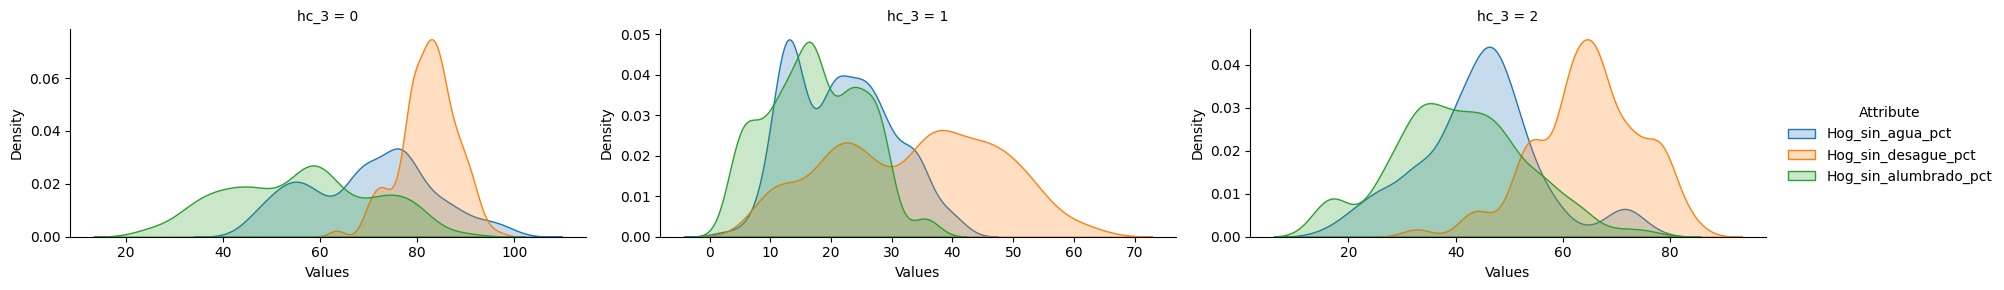

In [104]:
# Setup the facets
facets = sea.FacetGrid(
    data=dataprovmap_long,
    col="hc_3",
    hue="Attribute",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot as a `sns.kdeplot`
facets.map(sea.kdeplot, "Values", fill=True).add_legend()

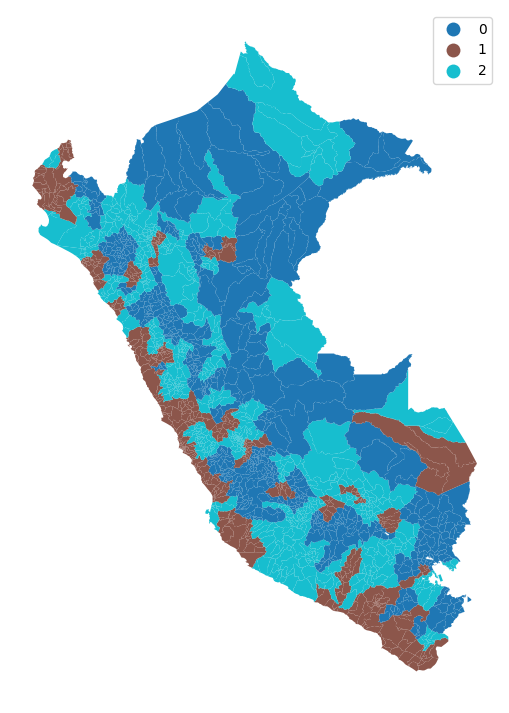

In [106]:
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
dataprovmap.plot(
    column="hc_3", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [108]:
pip install libpysal


     ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
     -- ------------------------------------- 0.1/2.4 MB 4.2 MB/s eta 0:00:01
     ------ --------------------------------- 0.4/2.4 MB 5.1 MB/s eta 0:00:01
     -------- ------------------------------- 0.5/2.4 MB 5.1 MB/s eta 0:00:01
     --------------- ------------------------ 0.9/2.4 MB 5.9 MB/s eta 0:00:01
     -------------------- ------------------- 1.2/2.4 MB 6.0 MB/s eta 0:00:01
     --------------------------- ------------ 1.6/2.4 MB 6.5 MB/s eta 0:00:01
     ------------------------------- -------- 1.9/2.4 MB 6.4 MB/s eta 0:00:01
     ------------------------------------- -- 2.3/2.4 MB 6.5 MB/s eta 0:00:01
     ---------------------------------------- 2.4/2.4 MB 6.3 MB/s eta 0:00:00


In [109]:
#se empieza a hacer la relacion con el GDF
from libpysal.weights import Queen, Rook, KNN

# rook
w_rook = Rook.from_dataframe(dataprovmap) 

C:\Users\HP SUPPORT\.conda\envs\prueba1\Lib\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\HP SUPPORT\.conda\envs\prueba1\Lib\site-packages\libpysal\cg\alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\HP SUPPORT\.conda\envs\prueba1\Lib\site-packages\libpysal\cg\alpha_shape

In [110]:
# rook
w_queen = Queen.from_dataframe(dataprovmap)

In [111]:
# k vecinos cercanos
w_knn = KNN.from_dataframe(dataprovmap, k=4)

In [115]:
# first one
dataprovmap.head(1)

DEPARTAMEN PROVINCIA                                           geometry  \
0      TACNA     TACNA  POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...   

       provDep  Hog_sin_agua_pct  Hog_sin_desague_pct  Hog_sin_alumbrado_pct  \
0  TACNA+TACNA          9.775825            20.815686              16.753091   

   EQ  FJ  JC  Hog_sin_agua_pct_t  Hog_sin_desague_pct_t  \
0   0   0   0            0.008509               0.065065   

   Hog_sin_alumbrado_pct_t  hc_3  
0                 0.142142     1

In [113]:
# amount neighbors of that district
w_rook.neighbors[0] 

[3]

<Axes: >

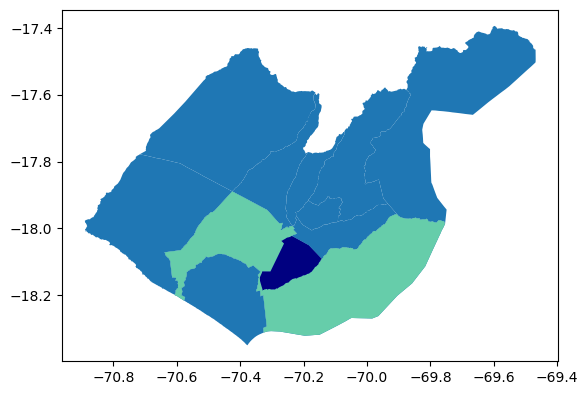

In [116]:
# see
base=dataprovmap[dataprovmap.PROVINCIA=="TACNA"].plot()
dataprovmap.iloc[w_rook.neighbors[0] ,].plot(ax=base,facecolor="mediumaquamarine")
dataprovmap.head(1).plot(ax=base,facecolor="navy")

In [117]:
w_queen.neighbors[0]

[1, 3]

<Axes: >

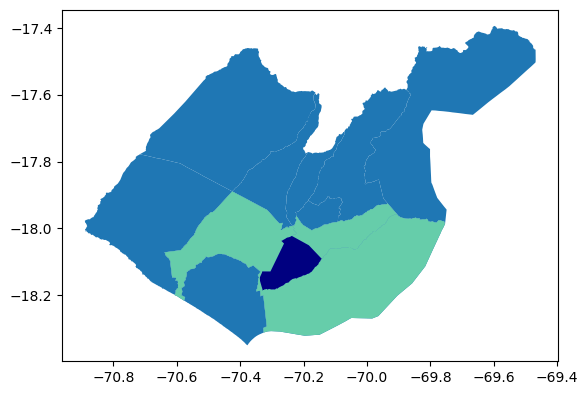

In [118]:
base=dataprovmap[dataprovmap.PROVINCIA=="TACNA"].plot()
dataprovmap.iloc[w_queen.neighbors[0] ,].plot(ax=base,facecolor="mediumaquamarine")
dataprovmap.head(1).plot(ax=base,facecolor="navy")

In [119]:
# all the neighbors by row
w_knn.neighbors

{0: [3, 2, 1, 10],
 1: [2, 3, 5, 0],
 2: [1, 5, 3, 6],
 3: [0, 1, 2, 5],
 4: [11, 10, 12, 8],
 5: [6, 2, 7, 1],
 6: [5, 2, 8, 7],
 7: [18, 5, 17, 2],
 8: [6, 20, 5, 25],
 9: [19, 18, 22, 7],
 10: [0, 3, 4, 2],
 11: [12, 14, 15, 4],
 12: [13, 11, 8, 4],
 13: [25, 27, 29, 12],
 14: [15, 11, 16, 12],
 15: [14, 16, 11, 33],
 16: [15, 14, 37, 33],
 17: [18, 20, 19, 7],
 18: [17, 19, 7, 20],
 19: [18, 23, 17, 21],
 20: [21, 17, 25, 26],
 21: [26, 20, 25, 27],
 22: [23, 19, 43, 9],
 23: [24, 19, 21, 22],
 24: [23, 21, 26, 30],
 25: [27, 26, 20, 21],
 26: [27, 25, 21, 28],
 27: [26, 25, 28, 29],
 28: [29, 27, 26, 30],
 29: [28, 27, 30, 26],
 30: [28, 29, 24, 27],
 31: [32, 33, 13, 29],
 32: [31, 34, 35, 56],
 33: [31, 16, 15, 32],
 34: [35, 56, 32, 60],
 35: [34, 56, 61, 60],
 36: [35, 34, 61, 30],
 37: [40, 38, 39, 16],
 38: [39, 42, 37, 40],
 39: [38, 42, 40, 37],
 40: [37, 38, 42, 39],
 41: [42, 89, 68, 39],
 42: [39, 38, 87, 40],
 43: [22, 48, 44, 23],
 44: [43, 45, 48, 24],
 45: [51, 54, 

In [120]:
# the matrix of neighboorhood:

pd.DataFrame(*w_knn.full()).astype(int) # 1 means both are neighbors

0     1     2     3     4     5     6     7     8     9     ...  1860  \
0        0     1     1     1     0     0     0     0     0     0  ...     0   
1        1     0     1     1     0     1     0     0     0     0  ...     0   
2        0     1     0     1     0     1     1     0     0     0  ...     0   
3        1     1     1     0     0     1     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     1     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1865     0     0     0     0     0     0     0     0     0     0  ...     0   
1866     0     0     0     0     0     0     0     0     0     0  ...     0   
1867     0     0     0     0     0     0     0     0     0     0  ...     0   
1868     0     0     0     0     0     0     0     0     0     0  ...     0   
1869     0     0     0     0     0     0     0     0     0     0  ...     0   

      1861  1862  1863  1864  1865  1866  1867  1868  1869  
0        0     0     0     0     0     0     0     0     0  
1        0     0     0     0     0     0     0     0     0  
2        0     0     0     0     0     0     0     0     0  
3        0     0     0     0     0     0     0     0     0  
4        0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
1865     0     0     0     0     0     1     1     0     0  
1866     0     0     0     1     1     0     1     0     0  
1867     0     0     0     0     1     1     0     1     0  
1868     0     0     0     1     0     1     1     0     0  
1869     0     0     1     0     0     0     0     0     0  

[1870 rows x 1870 columns]

In [121]:
# count of zeros
w_knn.nonzero

7480

In [122]:
# pct of neighboorhood (density)
w_knn.pct_nonzero

0.21390374331550802

In [123]:
# a district with NO neighbor?
w_knn.islands

[]

In [124]:
# needed for spatial correlation
w_knn.transform = 'R'

In [126]:
pip install esda

     ---------------------------------------- 0.0/116.6 kB ? eta -:--:--
     ------------------------------------ - 112.6/116.6 kB 3.2 MB/s eta 0:00:01
     -------------------------------------- 116.6/116.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for esda: filename=esda-2.4.3-py3-none-any.whl size=122796 sha256=ece0d06d078ecfd253abc2ea15c2d5a998febd619a3633ba56c98da823ea08d4
  Stored in directory: c:\users\hp support\appdata\local\pip\cache\wheels\09\a4\30\e76e9fcdd5d5b404825e9b50d7604db8dee59a5f5e6aa8fec6
Successfully built esda
Note: you may need to restart the kernel to use updated packages.


In [127]:
from esda.moran import Moran

moranIDH = Moran(dataprovmap['Hog_sin_desague_pct'], w_knn)
moranIDH.I,moranIDH.p_sim

(0.8142390014277671, 0.001)

In [129]:
pip install splot

     ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
     ---------------------------------------- 61.1/61.1 kB ? eta 0:00:00
     ---------------------------------------- 0.0/220.2 kB ? eta -:--:--
     -------------------------------------  215.0/220.2 kB 6.6 MB/s eta 0:00:01
     -------------------------------------- 220.2/220.2 kB 4.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/214.8 kB ? eta -:--:--
     ------------------------------ ------- 174.1/214.8 kB 5.3 MB/s eta 0:00:01
     -------------------------------------- 214.8/214.8 kB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.1/5.7 MB 3.8 MB/s eta 0:00:02
     -- ------------------------------------- 0.3/5.7 MB 3.9 MB/s eta 0:00:02
     --- ------------------------------------ 0.5/5.7 MB 5.1 MB/s eta 0:00:02
     ----- ---------------------------------- 0.7/5.7 MB 4.6 MB/s eta 0:00:02
     -

In [130]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moranIDH, aspect_equal=True)
ax.set_xlabel('Hog_sin_desague_std')
ax.set_ylabel('SpatialLag_Hog_sin_desague_std')
plt.show()

In [131]:
# The scatterplot with local info
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisaIDH = Moran_Local(y=dataprovmap['Hog_sin_desague_pct'], w=w_knn,seed=2022)
fig, ax = moran_scatterplot(lisaIDH,p=0.05)
ax.set_xlabel('Hog_sin_desague_std')
ax.set_ylabel('Hog_sin_desague_std')
plt.show()

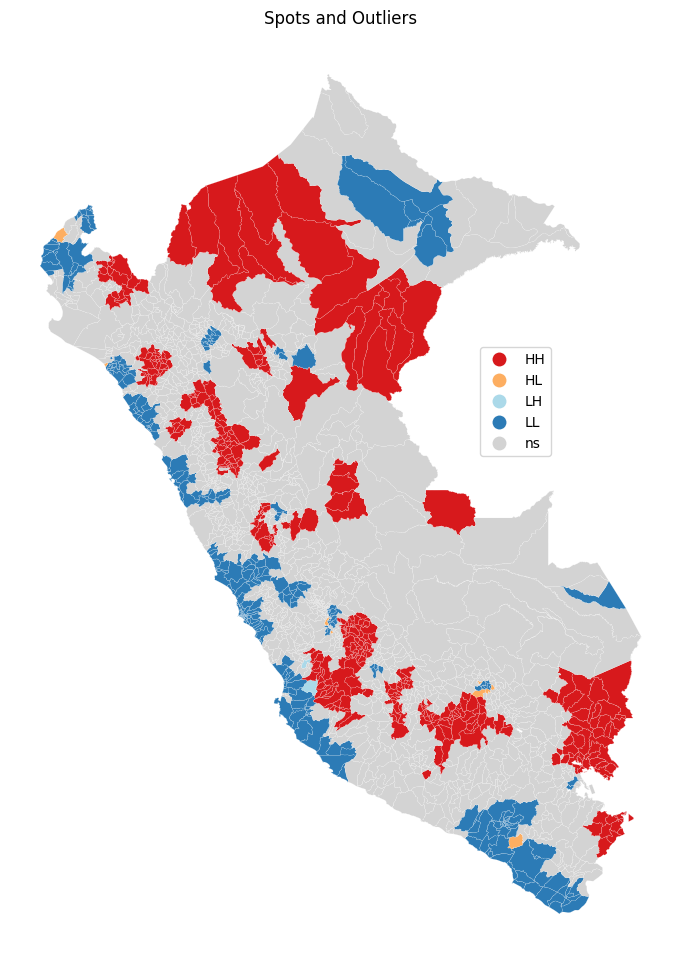

In [132]:
# the map with the spots and outliers

from splot.esda import lisa_cluster
f, ax = plt.subplots(1, figsize=(12, 12))
plt.title('Spots and Outliers')
fig = lisa_cluster(lisaIDH, 
                   dataprovmap,ax=ax,
                   legend_kwds={'loc': 'center left', 
                                'bbox_to_anchor': (0.7, 0.6)})
plt.show()

In [133]:
# quadrant
lisaIDH.q

array([3, 3, 3, ..., 3, 3, 3])

In [134]:
# significance
lisaIDH.p_sim

array([0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001])

In [135]:
# quadrant: 1 HH,  2 LH,  3 LL,  4 HL
pd.Series(lisaIDH.q).value_counts()

1    988
3    699
4    103
2     80
Name: count, dtype: int64

In [136]:
dataprovmap['hogar_sin_desague_quadrant']=[l if p <0.05 else 0 for l,p in zip(lisaIDH.q,lisaIDH.p_sim)  ]
dataprovmap['hogar_sin_desague_quadrant'].value_counts()

hogar_sin_desague_quadrant
0    1144
1     384
3     330
4      10
2       2
Name: count, dtype: int64

In [137]:
labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']

dataprovmap['hogar_sin_desague_quadrant_names']=[labels[i] for i in dataprovmap['hogar_sin_desague_quadrant']]

dataprovmap['hogar_sin_desague_quadrant_names'].value_counts()

hogar_sin_desague_quadrant_names
0 no_sig         1144
1 hotSpot         384
3 coldSpot        330
4 hotOutlier       10
2 coldOutlier       2
Name: count, dtype: int64

In [139]:
from matplotlib import colors
myColMap = colors.ListedColormap([ 'mediumaquamarine', 'indigo', 'slateblue', 'skyblue','teal'])



# Set up figure and ax
f, ax = plt.subplots(1, figsize=(12,12))
# Plot unique values choropleth including
# a legend and with no boundary lines

plt.title('Spots and Outliers')

dataprovmap.plot(column='hogar_sin_desague_quadrant_names', 
                categorical=True,
                cmap=myColMap,
                linewidth=0.1, 
                edgecolor='white',
                legend=True,
                legend_kwds={'loc': 'center left', 
                             'bbox_to_anchor': (0.7, 0.6)},
                ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [141]:
# final update
dataprovmap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='provinciaPeru', driver="GPKG")